In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpitree.tree import DecisionTreeClassifier

np.random.seed(42)

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris.data[:, :2], iris.target

In [3]:
clfs = [DecisionTreeClassifier(max_depth=depth).fit(X, y) for depth in (1, 2, 3, 5)]

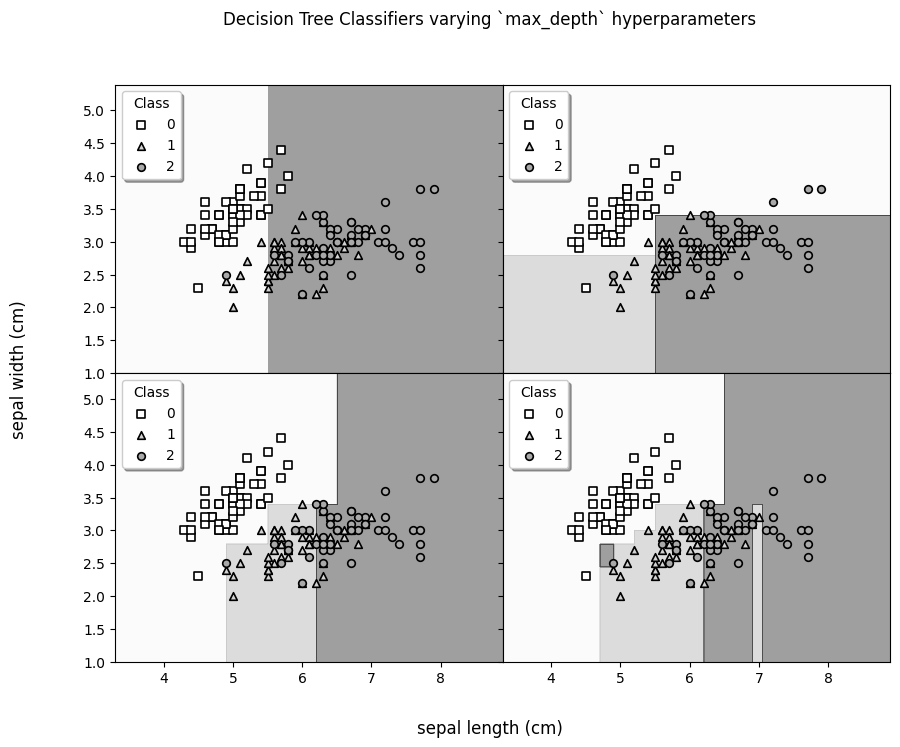

In [4]:
from itertools import product

n_classes = np.unique(y)
colors = "w", "lightgray", "darkgray"
markers = "s", "^", "o"

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

n_rows, n_cols = 2, 2
fig, axs = plt.subplots(
    n_rows,
    n_cols,
    sharex="col",
    sharey="row",
    figsize=(10, 7.5),
    gridspec_kw={"wspace": 0, "hspace": 0},
)

for idx, clf in zip(product(range(n_rows), range(n_cols)), clfs):
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    axs[idx[0], idx[1]].contourf(xx, yy, z, alpha=0.4, cmap="Greys")

    for t, c, marker in zip(n_classes, colors, markers):
        axs[idx[0], idx[1]].scatter(
            X[y == t, 0],
            X[y == t, 1],
            c=c,
            s=30,
            linewidth=1.2,
            marker=marker,
            edgecolors="k",
            label=t,
        )

    axs[idx[0], idx[1]].legend(title="Class", loc="upper left", shadow=True)

fig.suptitle("Decision Tree Classifiers varying `max_depth` hyperparameters")
fig.supxlabel("sepal length (cm)")
fig.supylabel("sepal width (cm)")

plt.show()

In [5]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

In [6]:
clf = DecisionTreeClassifier().fit(X, y)
print(clf)

┌── feature_1
│  ├── feature_0 [> 0.02]
│  │  ├── feature_1 [<= 1.42]
│  │  │  ├── feature_0 [<= 0.71]
│  │  │  │  ├── feature_0 [<= 0.31]
│  │  │  │  │  └── 1 [> -0.4]
│  │  │  │  │  └── 0 [<= -0.4]
│  │  │  │  └── 0 [> 0.31]
│  │  │  └── 0 [> 0.71]
│  │  └── 1 [> 1.42]
│  ├── feature_0 [<= 0.02]
│  │  ├── feature_1 [> -0.51]
│  │  │  ├── feature_1 [> -0.14]
│  │  │  │  └── 1 [> -0.12]
│  │  │  │  └── 0 [<= -0.12]
│  │  │  └── 1 [<= -0.14]
│  │  └── 0 [<= -0.51]


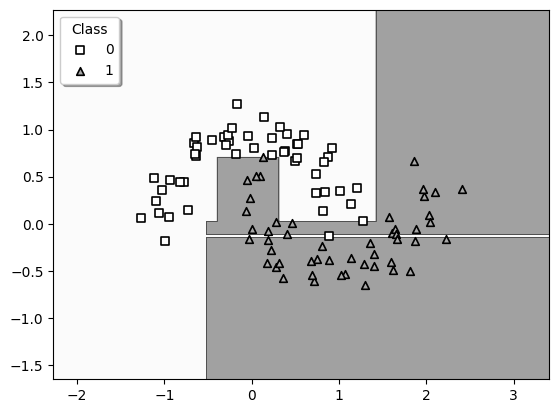

In [7]:
n_classes = np.unique(y)
colors = "w", "darkgray"
markers = "s", "^"

plt.figure()

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4, cmap="Greys")

for t, c, marker in zip(n_classes, colors, markers):
    plt.scatter(
        X[y == t, 0],
        X[y == t, 1],
        c=c,
        s=30,
        linewidth=1.2,
        marker=marker,
        edgecolors="k",
        label=t,
    )

plt.legend(title="Class", loc="upper left", shadow=True)
plt.show()